In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [101]:
# load dataset
df = pd.read_csv("base/heart.csv")
print(df.columns)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


Visualize os dados

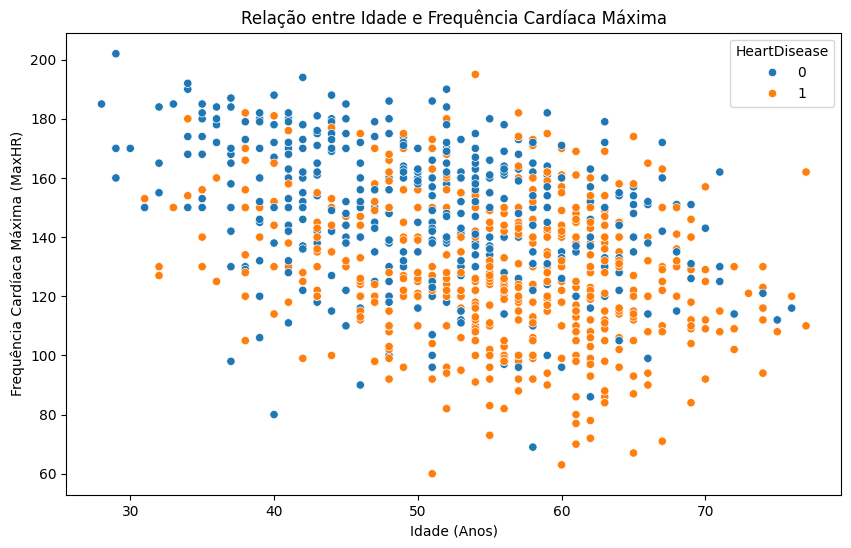

In [102]:
# Criando o scatter plot
plt.figure(figsize=(10, 6))  # Opcional: ajusta o tamanho do gráfico
sns.scatterplot(x=df["Age"], y=df["MaxHR"], hue=df["HeartDisease"])

# Adicionando títulos para clareza
plt.title("Relação entre Idade e Frequência Cardíaca Máxima")
plt.xlabel("Idade (Anos)")
plt.ylabel("Frequência Cardíaca Máxima (MaxHR)")

plt.show()

Corrigir os valores de zero

In [103]:
# Colunas com valores de zero que são clinicamente impossíveis
cols_to_correct = ["RestingBP", "Cholesterol"]

# Substituir 0 por NaN (Not a Number) para que possamos calcular a mediana corretamente
for col in cols_to_correct:
    df[col] = df[col].replace(0, np.nan)

# Calcular a mediana de cada coluna (ignorando os NaN) e preencher os valores faltantes
for col in cols_to_correct:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Verificar se ainda existem valores nulos ou zeros nessas colunas
print("Valores nulos após a correção:")
print(df[cols_to_correct].isnull().sum())
print("\nNovas estatísticas descritivas:")
print(df[cols_to_correct].describe())

Valores nulos após a correção:
RestingBP      0
Cholesterol    0
dtype: int64

Novas estatísticas descritivas:
        RestingBP  Cholesterol
count  918.000000   918.000000
mean   132.538126   243.204793
std     17.990127    53.401297
min     80.000000    85.000000
25%    120.000000   214.000000
50%    130.000000   237.000000
75%    140.000000   267.000000
max    200.000000   603.000000


Etapa 1: Aplicar o One-Hot Encoding

In [104]:
# Primeiro, identificamos as colunas que são realmente categóricas
# Note que não incluímos a variável alvo 'HeartDisease'
categorical_features = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

# Usamos pd.get_dummies para criar as novas colunas
# drop_first=True: Remove a primeira categoria de cada feature. Isso evita redundância (multicolinearidade).
# dtype=int: Cria as novas colunas com 0s e 1s em vez de True/False.
df_encoded = pd.get_dummies(
    df, columns=categorical_features, drop_first=True, dtype=int
)

# Vamos ver como ficou o novo DataFrame com as colunas transformadas
print("Colunas do DataFrame após o One-Hot Encoding:")
print(df_encoded.columns)
print("\nPrimeiras linhas do novo DataFrame:")
print(df_encoded.head())

Colunas do DataFrame após o One-Hot Encoding:
Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

Primeiras linhas do novo DataFrame:
   Age  RestingBP  Cholesterol  MaxHR  Oldpeak  HeartDisease  Sex_M  \
0   40      140.0        289.0    172      0.0             0      1   
1   49      160.0        180.0    156      1.0             1      0   
2   37      130.0        283.0     98      0.0             0      1   
3   48      138.0        214.0    108      1.5             1      0   
4   54      150.0        195.0    122      0.0             0      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_1  \
0                  1                  0                 0            0   
1                  0                  1     

Etapa 2: Nova Seleção de Recursos e Divisão
Seleção de recurso

- Variáveis independentes (features):
São as colunas que você usa como base para prever a target.

- Variável dependente (target):
A variável que você quer prever — neste caso, se a pessoa tem ou não doença cardíaca

In [105]:
# Agora, separamos X e y a partir deste NOVO DataFrame codificado
X = df_encoded.drop("HeartDisease", axis=1)  # remove a coluna target, fica só com as features
y = df_encoded["HeartDisease"]  # pega só a coluna target para prever

# O restante do processo continua igual!
# Dividimos os novos X e y em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=16
)

# Aplicamos a padronização
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

Otimização do Hiperparâmetro K para o KNN

In [106]:
from sklearn.metrics import f1_score  # Importe a métrica F1

# Encontrando o melhor valor de 'k' usando F1-Score
k_values = range(1, 17)
f1_scores = []  # Vamos armazenar os F1-Scores

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    # Calculamos o F1-Score ponderado (weighted) para levar em conta o suporte de cada classe
    f1_scores.append(f1_score(y_test, y_pred_knn, average="weighted"))

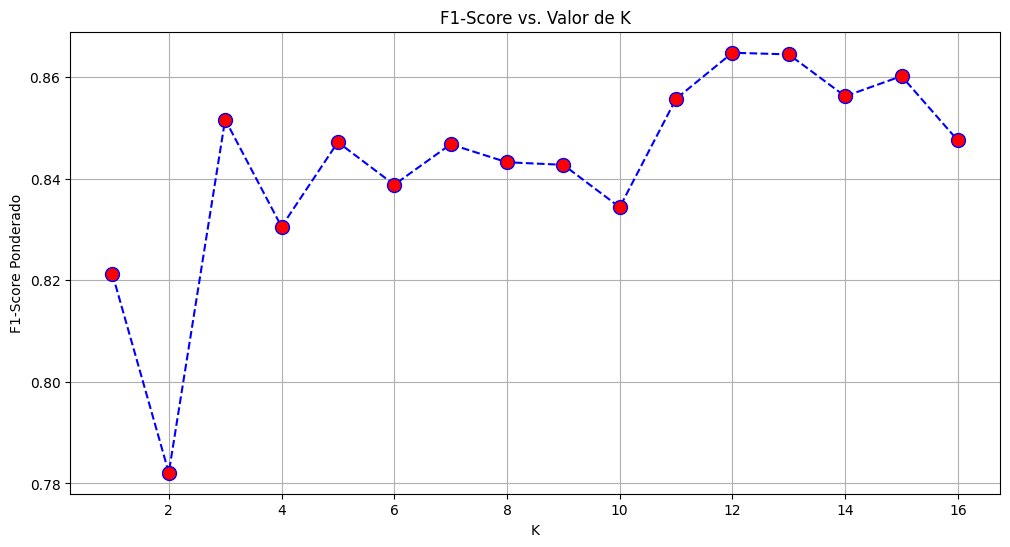

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(
    k_values,
    f1_scores,
    color="blue",
    linestyle="dashed",
    marker="o",
    markerfacecolor="red",
    markersize=10,
)
plt.title("F1-Score vs. Valor de K")
plt.xlabel("K")
plt.ylabel("F1-Score Ponderado")
plt.grid(visible=True)
plt.show()

Avaliando o modelo com o melhor 'k' Pelo seu gráfico, K=12 é uma excelente escolha

In [108]:
best_index = np.argmax(f1_scores)
best_k = k_values[best_index]
print(f"Best 'K': {best_k}")

Best 'K': 12


In [109]:
from sklearn.metrics import balanced_accuracy_score, f1_score

best_k_final = 12  # Atinge um recall maior que 12 - Com Doença

# Treina o modelo final
knn_final = KNeighborsClassifier(n_neighbors=best_k_final)
knn_final.fit(X_train_scaled, y_train)
y_pred_knn_final = knn_final.predict(X_test_scaled)

# 1. Calcular o F1-Score
f1 = f1_score(y_test, y_pred_knn_final, average="weighted")

# 2. Calcular a Acurácia Balanceada
balanced_acc = balanced_accuracy_score(y_test, y_pred_knn_final)


print(f"Avaliação do Modelo KNN com k={best_k_final}:")
print("=" * 40)
print(f"Acurácia Balanceada: {balanced_acc:.4f}")
print(f"F1-Score (Ponderado): {f1:.4f}")
print("=" * 40)

print("Relatório de Classificação Detalhado:")
print(
    classification_report(y_test, y_pred_knn_final, target_names=["Sem Doença", "Com Doença"])
)

Avaliação do Modelo KNN com k=12:
Acurácia Balanceada: 0.8629
F1-Score (Ponderado): 0.8648
Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

  Sem Doença       0.88      0.82      0.85       108
  Com Doença       0.85      0.90      0.88       122

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.87      0.87      0.86       230



In [110]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_knn_final)
cnf_matrix

array([[ 89,  19],
       [ 12, 110]])